In [305]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from IPython.core.interactiveshell import InteractiveShell
from datetime import timedelta
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df_before = pd.read_csv('CR_FC_PREP_0522.csv')
df_before['POD'] = pd.to_datetime(df_before['POD'])

df_before.head()
df_before.tail()
df_before.info()
print(f'Dataset size: {df_before.shape}')

,POD,RATE
0,2005-07-19,2200.0
1,2005-07-20,2250.0
2,2005-07-21,2300.0
3,2005-07-22,2280.0
4,2005-07-23,2260.0


,POD,RATE
6370,2022-12-27,4121.43
6371,2022-12-28,4142.86
6372,2022-12-29,4164.29
6373,2022-12-30,4185.71
6374,2022-12-31,4207.14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6375 entries, 0 to 6374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6375 non-null   datetime64[ns]
 1   RATE    6375 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 99.7 KB
Dataset size: (6375, 2)


In [306]:
print(df_before.columns)


Index(['POD', 'RATE'], dtype='object')


In [307]:
df_bf_indexed = df_before.set_index('POD')
print(df_bf_indexed.head())
print(df_bf_indexed.tail())
df_bf_indexed.info()

              RATE
POD               
2005-07-19  2200.0
2005-07-20  2250.0
2005-07-21  2300.0
2005-07-22  2280.0
2005-07-23  2260.0
               RATE
POD                
2022-12-27  4121.43
2022-12-28  4142.86
2022-12-29  4164.29
2022-12-30  4185.71
2022-12-31  4207.14
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6375 entries, 2005-07-19 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    6375 non-null   float64
dtypes: float64(1)
memory usage: 99.6 KB


In [308]:
# Y is the target
Y = df_before.pop('RATE') 
X = df_before

#normalise
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [309]:
def findRF(X_train, X_test, y_train, y_test):
    # Build the random forest model
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)

    # Predict the test data
    y_pred = rf_model.predict(X_test)

    # Calculate the root mean squared error
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # Calculate the R-squared value
    r2 = r2_score(y_test, y_pred)

    # Calculate the accuracy score in percentage
    mean = y_test.mean()
    accuracy = (1 - rmse/mean) * 100

    print("Root Mean Squared Error:", round(rmse, 3))
    print("R-squared Value:", round(r2, 3))
    print("Accuracy Score:", round(accuracy, 2), "%")

    return y_pred


In [310]:
n_periods = 52
y_pred_last_52 = findRF(X_train, X_test, y_train, y_test)[-n_periods:]
print(y_pred_last_52)

Root Mean Squared Error: 103.474
R-squared Value: 0.997
Accuracy Score: 93.5 %
[ 507.1839  700.     1375.7    1168.093   755.     1361.1428 8811.6
  568.3487 2248.4    8150.      207.65    900.     9987.1836  400.
  752.6317  941.3143 1609.8816  700.      600.      473.623  1200.
 1208.335   900.      534.4743  900.      900.     1200.     1496.4543
 1547.4996 1221.15    526.      342.      625.     1214.4004  499.7143
  755.     6798.8214  500.9999 1339.0692  752.7445 1684.3     400.
 9600.      846.5727  625.     2200.      500.5004  430.     7968.2935
  400.     1451.6574  370.365 ]


In [311]:
last_date = df_bf_indexed.index[-1]
start_date = last_date + timedelta(days=1)

print(start_date)

# Create a date range for the next 52 days
next_52_days = pd.date_range(start=start_date, periods=52, freq='D')

# Create a dataframe with the predicted values and dates
forecast_df = pd.DataFrame({'POD': next_52_days, 'RATE': y_pred_last_52})

# Set the index of the dataframe to be the date column
forecast_df.set_index('POD', inplace=True)

# Print the dataframe
print(forecast_df)
forecast_df.info()

2023-01-01 00:00:00
                 RATE
POD                  
2023-01-01   507.1839
2023-01-02   700.0000
2023-01-03  1375.7000
2023-01-04  1168.0930
2023-01-05   755.0000
2023-01-06  1361.1428
2023-01-07  8811.6000
2023-01-08   568.3487
2023-01-09  2248.4000
2023-01-10  8150.0000
2023-01-11   207.6500
2023-01-12   900.0000
2023-01-13  9987.1836
2023-01-14   400.0000
2023-01-15   752.6317
2023-01-16   941.3143
2023-01-17  1609.8816
2023-01-18   700.0000
2023-01-19   600.0000
2023-01-20   473.6230
2023-01-21  1200.0000
2023-01-22  1208.3350
2023-01-23   900.0000
2023-01-24   534.4743
2023-01-25   900.0000
2023-01-26   900.0000
2023-01-27  1200.0000
2023-01-28  1496.4543
2023-01-29  1547.4996
2023-01-30  1221.1500
2023-01-31   526.0000
2023-02-01   342.0000
2023-02-02   625.0000
2023-02-03  1214.4004
2023-02-04   499.7143
2023-02-05   755.0000
2023-02-06  6798.8214
2023-02-07   500.9999
2023-02-08  1339.0692
2023-02-09   752.7445
2023-02-10  1684.3000
2023-02-11   400.0000
2023-02-12  

<Figure size 3000x800 with 0 Axes>

Text(0.5, 1.0, 'Final Forecast of COST_RATE')

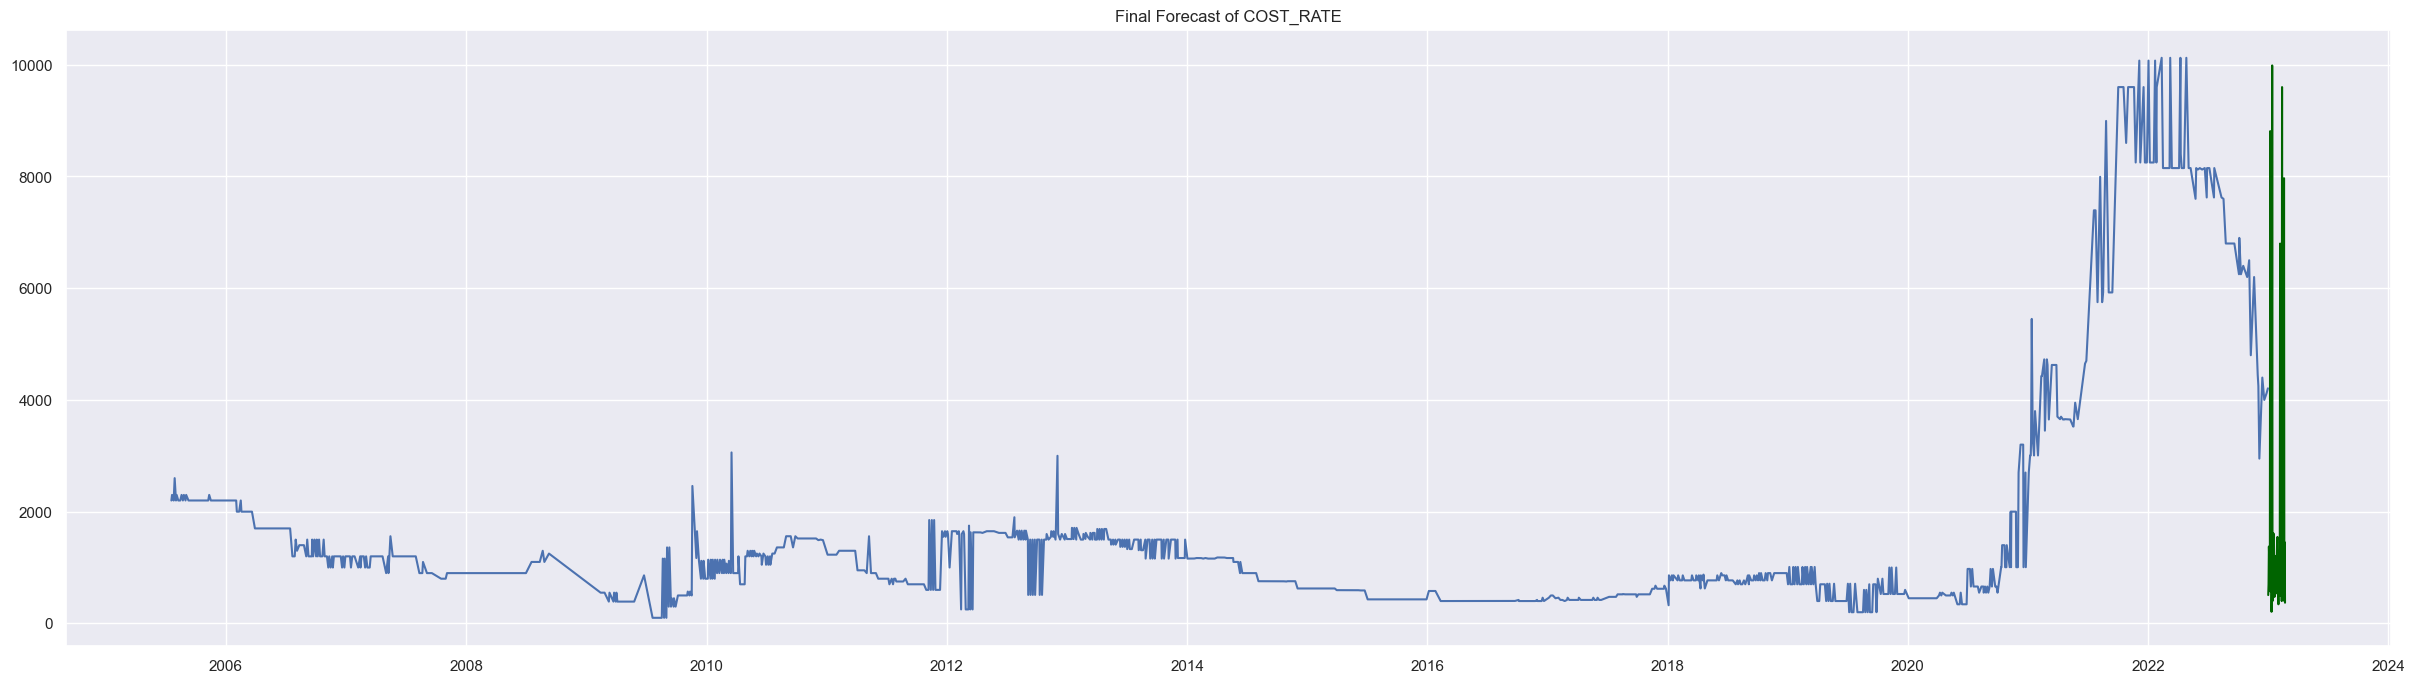

In [312]:
# Plot the forecast with current dataset
plt.figure(figsize=(30, 8))
plt.plot(df_bf_indexed)
plt.plot(forecast_df, color='darkgreen')
plt.title("Final Forecast of COST_RATE")
plt.show()

<h3>Comparing predicted with actual to check accuracy rate</h3>

In [313]:
# After 2023 data to compare accuracy of forecast
df_after = pd.read_csv('CR_FC_PREP_23.csv')
df_after['POD'] = pd.to_datetime(df_after['POD'])

df_after.set_index('POD',inplace=True)

df_after.head()
df_after.tail()
df_after.info()
print(f'Dataset size: {df_after.shape}')

,RATE
POD,
2023-01-01,4228.57
2023-01-02,4250.00
2023-01-03,2800.00
2023-01-04,2800.00
2023-01-05,2800.00


,RATE
POD,
2023-02-17,1500.0
2023-02-18,1500.0
2023-02-19,1500.0
2023-02-20,1500.0
2023-02-21,1500.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2023-01-01 to 2023-02-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    52 non-null     float64
dtypes: float64(1)
memory usage: 832.0 bytes
Dataset size: (52, 1)


In [315]:
import numpy as np

act_rate_arr = []
pred_rate_arr = []

for act_rate in df_after['RATE']:
    act_rate_arr.append(act_rate)

for pred_rate in y_pred_last_52:
    pred_rate_arr.append(pred_rate)

abs_diff_arr = [abs(act_rate_arr[i] - pred_rate_arr[i]) for i in range(len(act_rate_arr))]
print(abs_diff_arr)

[3721.386099999999, 3550.0, 1424.3, 1631.9070000000006, 2045.0, 1438.8572, 6011.6, 2231.6513, 551.5999999999999, 5387.5, 2517.35, 1787.5, 7337.183599999986, 2212.5, 1822.368300000001, 1596.1857000000005, 890.1184000000003, 1907.8200000000002, 2115.64, 2349.8269999999993, 1731.27, 1830.7550000000008, 2246.91, 2720.2557000000006, 2462.55, 2570.36, 2378.18, 2189.5456999999983, 1409.8304, 1007.52, 974.0, 1158.0, 875.0, 285.5996000000007, 1000.2857, 745.0, 5298.8214, 999.0001, 160.93080000000077, 747.2554999999994, 184.29999999999995, 1100.0, 8100.0, 653.4272999999994, 875.0, 700.0, 999.4995999999999, 1070.0, 6468.293499999989, 1100.0, 48.34260000000063, 1129.635]
